In [47]:
# All imports
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
import umap
import warnings
import time
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from sklearn.metrics.pairwise import manhattan_distances
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from tqdm.auto import tqdm
import gc

In [2]:
#random seed for reproducibility
np.random.seed(42)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# STEP 1: load + preprocess the data

# load data
data_df = pd.read_csv('data.csv')
taxonomy_df = pd.read_csv('taxonomy.csv')

# check if data is loaded correctly
print(f"Data loaded: {data_df.shape[0]} companies, {taxonomy_df.shape[0]} taxonomy labels")

# preprocess business tags
def preprocess_tags(tags_str):
    if pd.isna(tags_str) or tags_str == '':
        return []
    try:
        # string to array
        tags_str = tags_str.replace("'", '"')
        return ast.literal_eval(tags_str)
    except:
        return []


data_df['business_tags_list'] = data_df['business_tags'].apply(preprocess_tags)

# numbers for missing data
print(f"Nr of companies with missing descriptions: {data_df['description'].isna().sum()}")
print(f"Nr of companies with missing business tags: {data_df['business_tags'].isna().sum()}")
print(f"Nr of companies with missing sector: {data_df['sector'].isna().sum()}")
print(f"Nr of companies with missing category: {data_df['category'].isna().sum()}")
print(f"Nr of companies with missing niche: {data_df['niche'].isna().sum()}")

# fill missing values
data_df['description'] = data_df['description'].fillna('')
data_df['sector'] = data_df['sector'].fillna('')
data_df['category'] = data_df['category'].fillna('')
data_df['niche'] = data_df['niche'].fillna('')

# create new field - combined text - for each company
data_df['combined_text'] = data_df['description'] + ' ' + \
                         data_df['business_tags_list'].apply(lambda x: ' '.join(x)) + ' ' + \
                         data_df['sector'] + ' ' + \
                         data_df['category'] + ' ' + \
                         data_df['niche']

# taxonomy labels to list
taxonomy_labels = taxonomy_df['label'].tolist()

# preprocess taxonomy labels - create a lookup dictionary
taxonomy_lookup = {label.lower(): label for label in taxonomy_labels}

# I chose not to preprocess the data further since the text is already pretty structured and preprocessing might be detrimental
# ex key words like 'services', 'systems' etc and the semantic relationships should not be altered bcs it could lead to poorer classification performance
# classic steps like lemmatization or stop word remmoval could do more harm than good for the task

Data loaded: 9494 companies, 220 taxonomy labels
Nr of companies with missing descriptions: 12
Nr of companies with missing business tags: 0
Nr of companies with missing sector: 27
Nr of companies with missing category: 27
Nr of companies with missing niche: 0


STEP 2: Exploratory data analysis

Distribution of sectors:
sector
Manufacturing    4005
Services         3556
Wholesale         779
Retail            571
Government        255
Education         161
Non Profit        140
                   27
Name: count, dtype: int64

Word count statistics for company descriptions:
Average word count: 77.44
Maximum word count: 172
Minimum word count: 0

Business tags statistics:
Average number of tags per company: 8.15
Maximum number of tags: 61
Minimum number of tags: 0

Taxonomy label statistics:
Average words per label: 2.85
Maximum words per label: 6
Minimum words per label: 2

Check for direct matches between taxonomy labels and combined text

Top 20 taxonomy labels with direct matches in company data:
Consulting Services: 320
Financial Services: 134
Training Services: 91
Legal Services: 82
Printing Services: 76
Chemical Manufacturing: 75
Marketing Services: 74
Furniture Manufacturing: 67
Waste Management Services: 59
Management Consulting: 56
Re

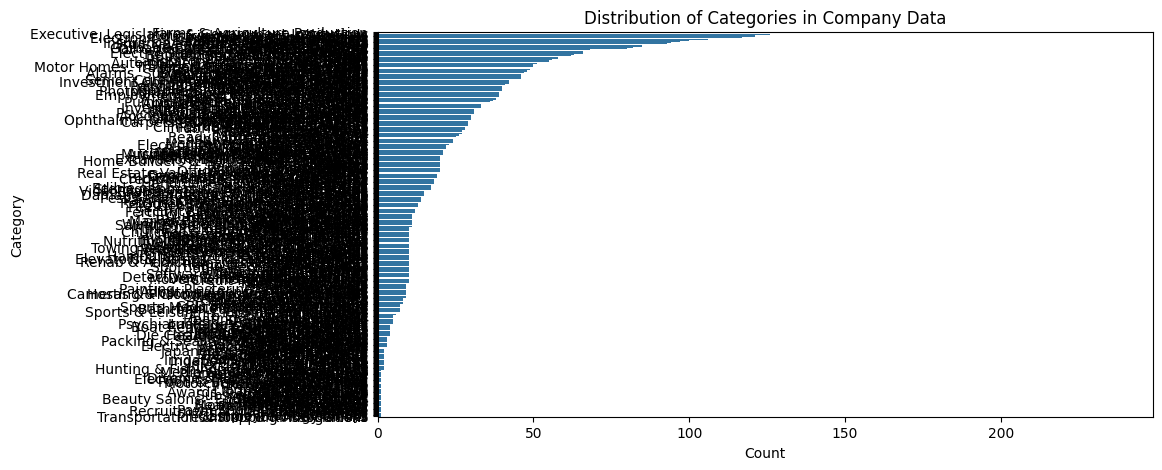

Exploratory data analysis completed in 10.13 seconds


In [39]:
# STEP 2: Exploratory data analysis
print("STEP 2: Exploratory data analysis")
start_time = time.time()

# distribution of company sectors
print("\nDistribution of sectors:")
sector_counts = data_df['sector'].value_counts().head(10)
print(sector_counts)

# distribution of word counts in descriptions
data_df['description_word_count'] = data_df['description'].apply(lambda x: len(x.split()) if x else 0)
print("\nWord count statistics for company descriptions:")
print(f"Average word count: {data_df['description_word_count'].mean():.2f}")
print(f"Maximum word count: {data_df['description_word_count'].max()}")
print(f"Minimum word count: {data_df['description_word_count'].min()}")

# distribution of tags per company
data_df['tags_count'] = data_df['business_tags_list'].apply(len)
print("\nBusiness tags statistics:")
print(f"Average number of tags per company: {data_df['tags_count'].mean():.2f}")
print(f"Maximum number of tags: {data_df['tags_count'].max()}")
print(f"Minimum number of tags: {data_df['tags_count'].min()}")

# label analysis
taxonomy_word_counts = [len(label.split()) for label in taxonomy_labels]
print("\nTaxonomy label statistics:")
print(f"Average words per label: {np.mean(taxonomy_word_counts):.2f}")
print(f"Maximum words per label: {np.max(taxonomy_word_counts)}")
print(f"Minimum words per label: {np.min(taxonomy_word_counts)}")

# check for direct matches between taxonomy labels and company data
# this will provide a general sense of how well some direct mathcing between embeddings would work
print("\nCheck for direct matches between taxonomy labels and combined text")
direct_matches = {}
for label in taxonomy_labels:
    label_lower = label.lower()
    match_count = data_df['combined_text'].str.lower().str.contains(label_lower).sum()
    direct_matches[label] = match_count

# sort and display top 20 matches
top_matches = sorted(direct_matches.items(), key=lambda x: x[1], reverse=True)[:20]
print("\nTop 20 taxonomy labels with direct matches in company data:")
for label, count in top_matches:
    print(f"{label}: {count}")

# labels with no matches
no_matches = [label for label, count in direct_matches.items() if count == 0]
print(f"\nNumber of taxonomy labels with no direct matches: {len(no_matches)}")
print(f"Percentage of labels with no direct matches: {len(no_matches)/len(taxonomy_labels)*100:.2f}%")

print("Total number of unique categories:", data_df['category'].nunique())
print("Total number of unique niches:", data_df['niche'].nunique())

# count distribution of categories in the company data
if 'category' in data_df.columns:
    print("\nCategory Distribution:")
    print(data_df['category'].value_counts())

    plt.figure(figsize=(10, 5))
    sns.countplot(y=data_df['category'], order=data_df['category'].value_counts().index)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.title("Distribution of Categories in Company Data")
    plt.show()

# time taken for exploratory analysis
eda_time = time.time() - start_time
print(f"Exploratory data analysis completed in {eda_time:.2f} seconds")

After looking at the raw data, I noticed the following things:
1. My first assumption was that the most specific labels should be applied for all companies. However, the dataset contains some companies with more areas of interest, which should be classified in a more specific way. Ideally, there should be a balance in the classification, where based on the attributes of each company, the ideal label is chosen. This fact also makes it less reliable to focus on keyword matching, since this may mean that a classification is too specific for a company focusing on more than one area of activity.
2. The keywords and sectors are most important for classification of services. Therefore preprocessing w lemmatization should not be applied, it could lead to poorer performance since the texts are already pretty short even when combined.
3. The categories are not necessarily a good measure of judging the dataset in terms of balance since they do not cover the entire dataset.
4. There is no general rule for how many labels should be assigned for each company. My initial assumption would be that there should be as few labels as possible, but this approach may mean that some companies would probably have incomplete labels.
5. My first assumption was that there was gonna be a direct correlation either between categories and labels or categories and niches, but there are 220 labels, 451 categories and 957 niches, so it would probably be best not to assume a correlation.

In [42]:
# STEP 3A: Features - TF-IDF(simple, less effective, no semantic similarity)
# Pros for tfidf: it would fit pretty well to the data since it contains pure word matches as was previously seen in the analysis
# Cons: fails if the terms are missing, which is also the case for parts of the data
print("\nSTEP 3: Embeddings with TF-IDF")
start_time = time.time()

# init TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    # min_df=5, max_df=0.8,
ngram_range=(2, 4), stop_words='english')

# fit and transform the company text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data_df['combined_text'])

# transform taxonomy labels
taxonomy_tfidf = tfidf_vectorizer.transform(taxonomy_labels)


print(f"Company TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Taxonomy TF-IDF matrix shape: {taxonomy_tfidf.shape}")
print(f"Number of features (vocabulary size): {len(tfidf_vectorizer.vocabulary_)}")

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_features_idx = tfidf_matrix.sum(axis=0).argsort()[0, ::-1][:50]
top_features = feature_names[top_features_idx.ravel()]
print("\nTop 20 most important TF-IDF features:")
print(top_features[:20])

# calc cos similarity between the complete company descriptions and taxonomy labels
similarity_matrix_tfidf = cosine_similarity(tfidf_matrix, taxonomy_tfidf)

# time taken for TF-IDF feature engineering
tfidf_time = time.time() - start_time
print(f"TF-IDF feature engineering completed in {tfidf_time:.2f} seconds")


STEP 3: Embeddings with TF-IDF
Company TF-IDF matrix shape: (9494, 1673634)
Taxonomy TF-IDF matrix shape: (220, 1673634)
Number of features (vocabulary size): 1673634

Top 20 most important TF-IDF features:
[['company specializes' 'high quality' 'services services' ...
  'traffic automotive' 'range products including neuviewer'
  'tag experiences laser']]
TF-IDF feature engineering completed in 11.26 seconds


In [43]:
# STEP 3B: BERT-based embeddings

# load a pre-trained sentence embedding model
# may lose nuances but it runs fast
# pros: more robust, captures context which should be important here
# cons: may introduce noise so spurious correlations taken wrongly as meaningful connections
# still intuitively it should perform better in this context than tfidf

# for the models, I tested 3 variants, the first 2 the fastest, with the last one a bit slower but more precise

# model = SentenceTransformer("all-MiniLM-L6-v2")  # Small & Fast - https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# model = SentenceTransformer("all-MiniLM-L12-v2") # gave labels to more companies, so it was more lenient
model = SentenceTransformer("all-mpnet-base-v2")   # more precise, a better choice here

# convert company descriptions & taxonomy labels into embeddings
company_embeddings = model.encode(data_df['combined_text'])
taxonomy_embeddings = model.encode(taxonomy_labels)

# compute similarity
similarity_matrix_bert = cosine_similarity(company_embeddings, taxonomy_embeddings)

In [13]:
# STEP 4: Baseline Model - Embeddings Similarity
print("\nSTEP 4: Baseline model")
start_time = time.time()

# baseline classification using a simple threshold
# this was the initial approach, I settled on threshold dinamically set based on percentages
# this should be a better choice since the threshold adapts to the data distribution in this way
# threshold = 0.5

# get similarity scores
similarity_scores_tfidf = similarity_matrix_tfidf.flatten()
similarity_scores_bert = similarity_matrix_bert.flatten()

threshold_tfidf = np.percentile(similarity_scores_tfidf, 95)
threshold_bert = np.percentile(similarity_scores_bert, 95)

# top labels for each company
def get_top_labels(similarity_row, threshold=0.1, top_n=5):
    # indices of labels above threshold
    label_indices = np.where(similarity_row > threshold)[0]

    # sort by similarity score
    sorted_indices = label_indices[np.argsort(-similarity_row[label_indices])]

    # top N
    top_indices = sorted_indices[:top_n]

    # return labels and scores
    return [(taxonomy_labels[i], similarity_row[i]) for i in top_indices]

# evaluate similarity matrix
def evaluate_similarity_matrix(similarity_matrix, matrix_name, threshold):
    print(f"\nEvaluating {matrix_name}")

    baseline_predictions = [get_top_labels(similarity_matrix[i], threshold) for i in range(similarity_matrix.shape[0])]

    # calc statistics
    labels_per_company = [len(preds) for preds in baseline_predictions]
    avg_labels = np.mean(labels_per_company)
    max_labels = np.max(labels_per_company)
    min_labels = np.min(labels_per_company)

    companies_with_labels = sum(1 for preds in baseline_predictions if len(preds) > 0)
    unique_labels_used = set(label for preds in baseline_predictions for label, _ in preds)

    # print statistics
    print(f"Threshold value({threshold}):")
    print(f"Baseline model metrics ({matrix_name}):")
    print(f"Average number of labels per company: {avg_labels:.2f}")
    print(f"Maximum number of labels assigned: {max_labels}")
    print(f"Minimum number of labels assigned: {min_labels}")
    print(f"Companies with at least one label: {companies_with_labels} ({companies_with_labels / len(data_df) * 100:.2f}%)")
    print(f"Number of unique taxonomy labels used: {len(unique_labels_used)} out of {len(taxonomy_labels)}")
    print(f"Percentage of taxonomy labels used: {len(unique_labels_used) / len(taxonomy_labels) * 100:.2f}%")

    return baseline_predictions

# eval both similarity matrices
baseline_predictions_tfidf = evaluate_similarity_matrix(similarity_matrix_tfidf, "TF-IDF", threshold_tfidf)
baseline_predictions_bert = evaluate_similarity_matrix(similarity_matrix_bert, "BERT", threshold_bert)

# add predictions to the dataframe for analysis
data_df["baseline_predictions_tfidf"] = baseline_predictions_tfidf
data_df["baseline_predictions_bert"] = baseline_predictions_bert

# time taken for baseline model
baseline_time = time.time() - start_time
print(f"Baseline model completed in {baseline_time:.2f} seconds")


STEP 4: Baseline model

Evaluating TF-IDF
Threshold value(0.009462824907620699):
Baseline model metrics (TF-IDF):
Average number of labels per company: 3.91
Maximum number of labels assigned: 5
Minimum number of labels assigned: 0
Companies with at least one label: 9035 (95.17%)
Number of unique taxonomy labels used: 220 out of 220
Percentage of taxonomy labels used: 100.00%

Evaluating BERT
Threshold value(0.33244067430496216):
Baseline model metrics (BERT):
Average number of labels per company: 3.29
Maximum number of labels assigned: 5
Minimum number of labels assigned: 0
Companies with at least one label: 7889 (83.09%)
Number of unique taxonomy labels used: 220 out of 220
Percentage of taxonomy labels used: 100.00%
Baseline model completed in 0.25 seconds


**Conclusion**: TF-IDF assigns labels to more companies maybe due to weak keyword matches, while BERT is more selective but may miss relevant ones.

**Other models for multi-label classification**:

For the models I took into consideration Zero Shot Learning and Unsupervised Learning.

Since the data is not annotated, supervised learning cannot be considered. Initially I also considered unsupervised learning with label matching(clustering based on the number of labels), but in case there are labels that don't match any company in the dataset, it would lead to incorrect classifications.

Few-shot learning would still require manual annotation so next I decided to go with Zero Shot Learning, since manual annotation would not scale well to large amounts of data.

In [44]:
model = "typeform/distilbert-base-uncased-mnli"  # lightweight model for maximized speed

# model = "facebook/bart-large-mnli"

# model = "MoritzLaurer/deberta-v3-base-mnli"


print("Loading model and tokenizer")
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).half()  # speed up inference
model.eval()

print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# preprocessing taxonomy labels in chunks to reduce mem usage
def process_taxonomy_labels(labels, chunk_size=50):
    chunks = [labels[i:i+chunk_size] for i in range(0, len(labels), chunk_size)]
    return chunks

# keep top N most relevant taxonomy labels per text
def filter_most_relevant_labels(similarity_matrix, taxonomy_labels, top_n=50):
    # already have the embeddings, just choose if to use tfidf/bert based
    relevant_labels_per_text = []

    # go through each company's similarity scores
    for sim_scores in similarity_matrix:
        # indices of top N most similar labels
        top_indices = np.argsort(sim_scores)[-top_n:]
        relevant_labels = [taxonomy_labels[idx] for idx in top_indices]
        relevant_labels_per_text.append(relevant_labels)

    return relevant_labels_per_text


def fast_zero_shot_classify(texts, all_relevant_labels, threshold=0.5, batch_size=64):
    results = []
    start_time = time.time()


    for batch_idx in tqdm(range(0, len(texts), batch_size), desc="processing text batches"):
        batch_texts = texts[batch_idx:batch_idx + batch_size]
        batch_labels = all_relevant_labels[batch_idx:batch_idx + batch_size]
        batch_results = []

        for text, text_labels in zip(batch_texts, batch_labels):
            text_results = []
            label_chunks = [text_labels[i:i+50] for i in range(0, len(text_labels), 50)]

            for labels in label_chunks:
                # input pairs (text paired with each label)
                pairs = []
                for label in labels:
                    pairs.append((text, label))

                # tokenize all pairs at once
                features = tokenizer(
                    [p[0] for p in pairs],
                    [p[1] for p in pairs],
                    padding=True,
                    truncation='only_first',
                    return_tensors="pt",
                    max_length=128  # Limit max length to increase speed
                ).to(device)

                # inference in a single batch for all labels
                with torch.no_grad():
                    outputs = model(**features)

                scores = torch.softmax(outputs.logits, dim=1)[:, 2].cpu().numpy()

                # add matching labels
                for i, (label, score) in enumerate(zip(labels, scores)):
                    if score >= threshold:
                        text_results.append((label, float(score)))

            # sort by score in descending order
            text_results.sort(key=lambda x: x[1], reverse=True)
            text_results = text_results[:3] # only keep max 3 labels
            batch_results.append(text_results)

        results.extend(batch_results)

        # clear memory
        torch.cuda.empty_cache()
        gc.collect()

        # progress
        elapsed = time.time() - start_time
        items_processed = batch_idx + batch_size
        items_per_second = items_processed / elapsed
        estimated_remaining = (len(texts) - items_processed) / items_per_second

        print(f"Processed {items_processed}/{len(texts)} items. "
              f"Speed: {items_per_second:.2f} items/sec. "
              f"Est. remaining: {estimated_remaining/60:.1f} min")

        # # save results every 500 samples
        # if (batch_idx + batch_size) % 500 == 0:
        #     interim_df = pd.DataFrame({
        #         'text_idx': list(range(len(results))),
        #         'assigned_labels': [[label for label, _ in res] for res in results]
        #     })
        #     interim_df.to_csv(f'interim_results_{batch_idx}.csv', index=False)

    print(f"Classification completed in {(time.time() - start_time)/60:.2f} minutes")
    return results


def main():

    # data_df = data_df.head(1000)  # for testing with subset

    texts = data_df['combined_text'].tolist()
    taxonomy_labels = taxonomy_df['label'].tolist()

    print("pre-filtering relevant labels per text")
    top_n = min(50, len(taxonomy_labels))
    relevant_labels_per_text = filter_most_relevant_labels(similarity_matrix_tfidf, taxonomy_labels, top_n=top_n)
    # relevant_labels_per_text = filter_most_relevant_labels(similarity_matrix_bert, taxonomy_labels, top_n=top_n)

    print("zero-shot classification")
    # batch_size = 128
    batch_size = 64
    results = fast_zero_shot_classify(texts, relevant_labels_per_text, threshold=0.5, batch_size=batch_size)

    data_df['assigned_labels'] = [[label for label, _ in item_results] for item_results in results]
    data_df.to_csv('classification_results_final.csv', index=False)

    print("Classification completed and results saved!")

if __name__ == "__main__":
    main()


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Loading model and tokenizer


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


Using device: cuda
GPU: Tesla T4
pre-filtering relevant labels per text
zero-shot classification


processing text batches:   0%|          | 0/149 [00:00<?, ?it/s]

Processed 64/9494 items. Speed: 15.47 items/sec. Est. remaining: 10.2 min
Processed 128/9494 items. Speed: 16.57 items/sec. Est. remaining: 9.4 min
Processed 192/9494 items. Speed: 17.49 items/sec. Est. remaining: 8.9 min
Processed 256/9494 items. Speed: 17.95 items/sec. Est. remaining: 8.6 min
Processed 320/9494 items. Speed: 17.34 items/sec. Est. remaining: 8.8 min
Processed 384/9494 items. Speed: 17.44 items/sec. Est. remaining: 8.7 min
Processed 448/9494 items. Speed: 17.71 items/sec. Est. remaining: 8.5 min
Processed 512/9494 items. Speed: 17.33 items/sec. Est. remaining: 8.6 min
Processed 576/9494 items. Speed: 17.49 items/sec. Est. remaining: 8.5 min
Processed 640/9494 items. Speed: 17.67 items/sec. Est. remaining: 8.4 min
Processed 704/9494 items. Speed: 17.72 items/sec. Est. remaining: 8.3 min
Processed 768/9494 items. Speed: 17.65 items/sec. Est. remaining: 8.2 min
Processed 832/9494 items. Speed: 17.71 items/sec. Est. remaining: 8.2 min
Processed 896/9494 items. Speed: 17.86

After running for the first time, I noticed that the model outputs in some cases a very large number of labels for some companies. I decided to only keep max 3 labels, in order to not make the labeling redundant. I also tested multiple models with different speed accuracy tradeoffs.

Multi-label classification with zero shot learning has some poor results for many of the companies, returning unrelated labels even as a second option. What can contribute to this is firstly the model itself, since I chose a lightweight one for better speed. The embeddings can also play a role here, as well as the threshold used(it may be too low). The time it takes for the model to run greatly depends as well on how many top N labels are considered for each company.

Taking all this into consideration, I decided to settle on only returning the best matching label in the end. Given the nature of the task, this may lead to an improved performance.

Given the performance of the zero shot classification,I decided for the final model to combine direct keyword matching with embedding similarity. For the embedding similarity what should matter most are the semantic relationships, since this is the fallback to not finding direct matches between company data and the labels.

In [49]:
def final_classification(data_df, taxonomy_labels, company_embeddings, taxonomy_embeddings,
                               similarity_threshold=0.25):

    start_time = time.time()
    print("Starting final classification")

    # normalize embeddings
    company_embeddings = company_embeddings / np.linalg.norm(company_embeddings, axis=1, keepdims=True)
    taxonomy_embeddings = taxonomy_embeddings / np.linalg.norm(taxonomy_embeddings, axis=1, keepdims=True)

    # find direct matches in text
    def find_direct_matches(text, labels):
        matches = []
        # sorting labels by length desc to prioritize more specific matches
        # assuming here that longer labels are more specific, this is not necessarily true
        sorted_labels = sorted(labels, key=len, reverse=True)

        # case-insensitive matching
        text_lower = str(text).lower()

        for label in sorted_labels:
            # match whole words or phrases to avoid wrong partial matches(ex Car - Carpet)
            pattern = r'\b' + re.escape(label.lower()) + r'\b'
            if re.search(pattern, text_lower):
                matches.append(label)

        return matches

    # process each company
    best_company_labels = []
    direct_match_count = 0
    similarity_match_count = 0

    for i in tqdm(range(len(data_df))):
        company_text = data_df.iloc[i]['combined_text']

        # try to find direct matches in the company text
        direct_matches = find_direct_matches(company_text, taxonomy_labels)

        if direct_matches:
            best_company_labels.append(direct_matches[0])
            direct_match_count += 1

        else:
            # fallback to similarity if no direct matches
            # similarities = np.dot(company_embeddings[i], taxonomy_embeddings.T)
            similarities = util.cos_sim(company_embeddings[i], taxonomy_embeddings)[0]  # Extract single row

            best_idx = np.argmax(similarities)
            best_sim = similarities[best_idx]

            if best_sim >= similarity_threshold:
                best_company_labels.append(taxonomy_labels[best_idx])
                similarity_match_count += 1
            else:
                best_company_labels.append("")

    # Add predictions to dataframe
    data_df['insurance_label'] = best_company_labels

    # Evaluate model performance
    print("\nData-Aligned Classification Performance:")
    print(f"Direct matches found: {direct_match_count} ({direct_match_count/len(data_df)*100:.2f}%)")
    print(f"Similarity-based matches: {similarity_match_count} ({similarity_match_count/len(data_df)*100:.2f}%)")
    evaluate_performance(data_df, taxonomy_labels)

    print(f"Classification completed in {time.time() - start_time:.2f} seconds")

    return data_df

def evaluate_performance(data_df, taxonomy_labels):
    """Enhanced performance evaluation with additional metrics"""
    # Count companies with a label
    companies_with_labels = (data_df['insurance_label'] != "").sum()

    # Count unique labels used
    unique_labels_used = set(data_df['insurance_label']) - {""}

    # Label distribution
    label_counts = data_df['insurance_label'].value_counts()
    top_labels = label_counts.head(30)

    print(f"Companies with a label: {companies_with_labels} ({companies_with_labels/len(data_df)*100:.2f}%)")
    print(f"Companies without a label: {len(data_df) - companies_with_labels} ({(len(data_df) - companies_with_labels)/len(data_df)*100:.2f}%)")
    print(f"Number of unique taxonomy labels used: {len(unique_labels_used)} out of {len(taxonomy_labels)}")
    print(f"Percentage of taxonomy labels used: {len(unique_labels_used)/len(taxonomy_labels)*100:.2f}%")
    print(f"\nTop 30 most common labels:")
    for label, count in top_labels.items():
        if label:  # skip empty string
            print(f"  - {label}: {count} companies ({count/len(data_df)*100:.2f}%)")

# run classification
result_df = final_classification(
    data_df,
    taxonomy_labels,
    company_embeddings,
    taxonomy_embeddings,
    similarity_threshold=0.25
)

result_df.to_csv('companies_with_aligned_label.csv', index=False)


Starting final classification


  0%|          | 0/9494 [00:00<?, ?it/s]


Data-Aligned Classification Performance:
Direct matches found: 1799 (18.95%)
Similarity-based matches: 7413 (78.08%)
Companies with a label: 9212 (97.03%)
Companies without a label: 282 (2.97%)
Number of unique taxonomy labels used: 211 out of 220
Percentage of taxonomy labels used: 95.91%

Top 30 most common labels:
  - Travel Services: 238 companies (2.51%)
  - Agricultural Equipment Services: 219 companies (2.31%)
  - Consulting Services: 205 companies (2.16%)
  - Confectionery Manufacturing: 197 companies (2.07%)
  - Financial Services: 187 companies (1.97%)
  - Sheet Metal Services: 184 companies (1.94%)
  - Accessory Manufacturing: 183 companies (1.93%)
  - Textile Manufacturing Services: 173 companies (1.82%)
  - Commercial Electrical Services: 171 companies (1.80%)
  - Furniture Manufacturing: 166 companies (1.75%)
  - Livestock Dealer Services: 140 companies (1.47%)
  - Cosmetic Manufacturing: 130 companies (1.37%)
  - Food Processing Services: 128 companies (1.35%)
  - Chemi

In [55]:
data_df = pd.read_csv("companies_with_aligned_label.csv")

def extract_labels(pred_col):
    def safe_extract(preds):
        if isinstance(preds, str):
            try:
                preds = eval(preds)
            except:
                return []
        if isinstance(preds, list):
            return [label for label, _ in preds if isinstance(label, str)]
        return []
    return pred_col.apply(safe_extract)

data_df["labels_tfidf"] = extract_labels(data_df["baseline_predictions_tfidf"])
data_df["labels_bert"] = extract_labels(data_df["baseline_predictions_bert"])

data_df["labels_insurance"] = data_df["insurance_label"].apply(lambda x: [x] if pd.notnull(x) and x != "" else [])

label_counts_tfidf = data_df["labels_tfidf"].explode().value_counts()
label_counts_bert = data_df["labels_bert"].explode().value_counts()
label_counts_insurance = data_df["labels_insurance"].explode().value_counts()

print(f"\nTF-IDF: {label_counts_tfidf.shape[0]} unique labels used / 220 total")
print(label_counts_tfidf.head(20))

print(f"\nBERT: {label_counts_bert.shape[0]} unique labels used / 220 total")
print(label_counts_bert.head(20))

print(f"\nInsurance Model: {label_counts_insurance.shape[0]} unique labels used / 220 total")
print(label_counts_insurance.head(20))

# #  BERT label distribution
# plt.figure(figsize=(10, 6))
# label_counts_bert.head(20).plot(kind='barh', color='skyblue')
# plt.title("Top 20 Labels Assigned by BERT Model")
# plt.xlabel("Number of Companies")
# plt.ylabel("Label")
# plt.gca().invert_yaxis()  # Most frequent at top
# plt.tight_layout()
# plt.show()



TF-IDF: 220 unique labels used / 220 total
labels_tfidf
Well Maintenance Services          840
Plastic Manufacturing              792
Consulting Services                659
Fire Safety Equipment Services     453
Waste Management Services          448
Wood Product Manufacturing         437
Animal Day Care Services           418
Pet Food Manufacturing             415
Fencing Construction Services      413
Frozen Food Processing             412
Project Management Services        405
Ice Production Services            401
Training Services                  399
Street Cleaning Operations         393
Agricultural Equipment Services    392
Interior Design Services           391
Software Development Services      390
Financial Services                 379
Furniture Manufacturing            367
Online Marketing Services          358
Name: count, dtype: int64

BERT: 220 unique labels used / 220 total
labels_bert
Agricultural Equipment Services     700
Accessory Manufacturing             660
She

TF-IDF long-tail labels (<10): 3
BERT long-tail labels (<10): 10
Insurance long-tail labels (<10): 35


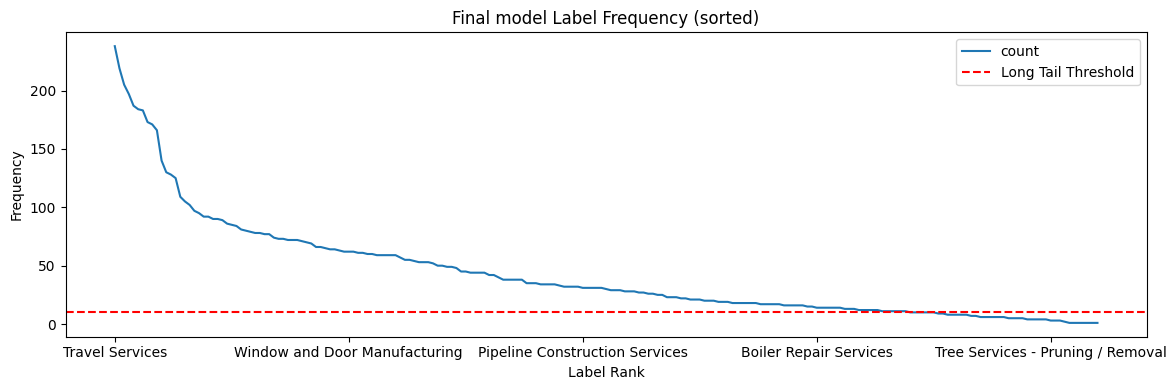

In [59]:
long_tail_threshold = 10
tail_tfidf = label_counts_tfidf[label_counts_tfidf < long_tail_threshold]
tail_bert = label_counts_bert[label_counts_bert < long_tail_threshold]
tail_insurance = label_counts_insurance[label_counts_insurance < long_tail_threshold]

print(f"TF-IDF long-tail labels (<{long_tail_threshold}): {len(tail_tfidf)}")
print(f"BERT long-tail labels (<{long_tail_threshold}): {len(tail_bert)}")
print(f"Insurance long-tail labels (<{long_tail_threshold}): {len(tail_insurance)}")



plt.figure(figsize=(12, 4))
label_counts_insurance.sort_values(ascending=False).plot(kind="line", title="Final model Label Frequency (sorted)")
plt.axhline(10, color='red', linestyle='--', label="Long Tail Threshold")
plt.legend()
plt.xlabel("Label Rank")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



In [60]:
def evaluate_model_predictions(column, label_counts, model_name):
    total_companies = len(data_df)
    companies_with_labels = data_df[column].apply(lambda x: len(x) > 0).sum()
    avg_labels_per_company = data_df[column].apply(len).mean()
    unique_labels_used = label_counts.shape[0]
    long_tail_labels = (label_counts < 5).sum()

    print(f"--- {model_name} ---")
    print(f"Companies with labels: {companies_with_labels} / {total_companies} ({companies_with_labels / total_companies * 100:.1f}%)")
    print(f"Average labels per company: {avg_labels_per_company:.2f}")
    print(f"Unique labels assigned: {unique_labels_used} / {len(taxonomy_labels)}")
    print(f"Labels used fewer than 5 times: {long_tail_labels}")
    print()


evaluate_model_predictions("labels_tfidf", label_counts_tfidf, "TF-IDF Model")
evaluate_model_predictions("labels_bert", label_counts_bert, "BERT Model")
evaluate_model_predictions("labels_insurance", label_counts_insurance, "Insurance Model")


--- TF-IDF Model ---
Companies with labels: 9035 / 9494 (95.2%)
Average labels per company: 3.91
Unique labels assigned: 220 / 220
Labels used fewer than 5 times: 1

--- BERT Model ---
Companies with labels: 7889 / 9494 (83.1%)
Average labels per company: 3.29
Unique labels assigned: 220 / 220
Labels used fewer than 5 times: 4

--- Insurance Model ---
Companies with labels: 9212 / 9494 (97.0%)
Average labels per company: 0.97
Unique labels assigned: 211 / 220
Labels used fewer than 5 times: 16



What would be useful to check in performance as well: Inter-Model agreement: how do the classifications match or semantic consistency between what different models assigned(ex if one assigned “Software Development” and another “IT Consulting”, this would be a good prediction because they are semantically close).

Further possible improvements:
1. More powerful models\ model refinement used for the zero shot classification
2. Ensemble methods for combining more models for better prediction
3. Clustering in validation to check if similar companies get similar labels

In [62]:
original_df = pd.read_csv("data.csv")
labels_df = pd.read_csv("companies_with_aligned_label.csv")

# if len(original_df) != len(labels_df):
#     raise ValueError(f"Mismatch in number of rows: original ({len(original_df)}) vs labels ({len(labels_df)})")

original_df["insurance_label"] = labels_df["insurance_label"]

original_df.to_csv("ml_insurance_challenge.csv", index=False)
print("File saved")


File saved
